In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable

In [2]:
def findInterval(T):
    min_a = 0
    max_b = 100

    low, high = 0, 0
    while (low == high):
        ab = np.random.randint(min_a, max_b , size=2)
        low, high = T*min(ab)/(max_b-min_a), T*max(ab)/(max_b-min_a)
#         print(min(ab), max(ab))
    return low, high

In [53]:
f = 40
T = 1/f
w = 2*np.pi*f
A = 1

n_features = 10
n_train_samples = 5000

X_train = np.zeros((n_train_samples, n_features))
y_train = np.zeros((n_train_samples, n_features))

for i in range(n_train_samples):
    t1, t2 = findInterval(T)
    t = np.linspace(t1, t2, n_features)
    X_train[i] = A*np.sin(w*t)
    y_train[i] = A*np.cos(w*t)

inputs = torch.from_numpy(X_train.reshape((n_train_samples, n_features, -1))).float()
targets = torch.from_numpy(y_train.reshape((n_train_samples, n_features, -1))).float()


In [31]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    

GPU not available, CPU used
cpu


In [7]:
class Modelo(nn.Module):
    
    def __init__(self, rnn_type='rnn'):
        super(Modelo, self).__init__()
        
        self.rnn_type = rnn_type
        
        self.rnn = nn.RNN(input_size=10, 
                   hidden_size=10, batch_first=True)
        
        self.lstm = nn.LSTM(input_size=10,
                           hidden_size=10, batch_first=True)
        
        self.gru = nn.gru(input_size=10,
                           hidden_size=10, batch_first=True)
        
    def forward(self, x, hidden, cell=None):
        
#       (batch_size , sequence_length , input_size)
        x = x.view(1, 1, 10)
    
        if self.rnn_type =='lstm':
            out, (hidden, cell) = self.lstm(x, (hidden, cell))
            out = out.view(-1)
            return hidden, cell, out
        elif self.rnn_type == 'gru': 
            out, hidden = self.gru(x, hidden)
            out = out.view(-1)
            return hidden, out
        elif self.rnn_type == 'rnn':      
            out, hidden = self.rnn(x, hidden)
            out = out.view(-1)
            return hidden, out
    
    def init_cell(self):
        
#       (num_layers*num_directions , batch , hidden_size)
        return Variable(torch.zeros(1, 1, 10))
        
    def init_hidden(self):
        
#       (num_layers*num_directions , batch , hidden_size)
        return Variable(torch.zeros(1, 1, 10))
    

In [40]:
def trainedRNNModel(model, inputs, targets, criterion, optimizer, n_ecochs, device):

    rnn_type = model.rnn_type
    for epoch in range(n_epochs):

        model.train()

        hidden = model.init_hidden()
        cell = model.init_cell()
        
        loss = 0.0
        for input, target in zip(inputs, targets):

    #       wrap in Variable
            input, target = Variable(input.to(device)), Variable(target.view(-1).to(device))

            if rnn_type=='lstm':
    #           LSTM        
    #           feed the input and acquire the output from network
                hidden, cell, output = model(input, hidden, cell)
            elif (rnn_type == 'gru') or (rnn_type == 'rnn'):
                
    #           GRU or RNN
    #           feed the input and acquire the output from network 
                hidden, output = model(input, hidden)

    #       calculating the predicted and the expected loss
            loss += criterion(output.float(), target.float())

    #   clear the gradient
        optimizer.zero_grad()

    #   compute the gradient
        loss.backward()

    #   update the parameters
        optimizer.step()     
        if (epoch+1) % 5 == 0:
            print("epoch: %d, loss: %1.4f" % (epoch + 1, loss.data/inputs.size(0)))
        
    return model

In [96]:
n_epochs = 50
model = Modelo().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-4)
trained_model_rnn = trainedRNNModel(model, inputs, targets, criterion, optimizer, n_epochs, device)

epoch: 5, loss: 0.1979
epoch: 10, loss: 0.1943
epoch: 15, loss: 0.1492
epoch: 20, loss: 0.1362
epoch: 25, loss: 0.1248
epoch: 30, loss: 0.1177
epoch: 35, loss: 0.1126
epoch: 40, loss: 0.1087
epoch: 45, loss: 0.1055
epoch: 50, loss: 0.1028


In [97]:
n_epochs = 70
model = Modelo(rnn_type='lstm').to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
trained_model_lstm = trainedRNNModel(model, inputs, targets, criterion, optimizer, n_epochs, device)

epoch: 5, loss: 0.2519
epoch: 10, loss: 0.2040
epoch: 15, loss: 0.1868
epoch: 20, loss: 0.1847
epoch: 25, loss: 0.1510
epoch: 30, loss: 0.1429
epoch: 35, loss: 0.1297
epoch: 40, loss: 0.1471
epoch: 45, loss: 0.1186
epoch: 50, loss: 0.1078
epoch: 55, loss: 0.1174
epoch: 60, loss: 0.1161
epoch: 65, loss: 0.0996
epoch: 70, loss: 0.0934


In [100]:
n_epochs = 50
model = Modelo(rnn_type='gru').to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=7e-4)
trained_model_gru = trainedRNNModel(model, inputs, targets, criterion, optimizer, n_epochs, device)

epoch: 5, loss: 0.2196
epoch: 10, loss: 0.1834
epoch: 15, loss: 0.1466
epoch: 20, loss: 0.1306
epoch: 25, loss: 0.1229
epoch: 30, loss: 0.1192
epoch: 35, loss: 0.1136
epoch: 40, loss: 0.1069
epoch: 45, loss: 0.1015
epoch: 50, loss: 0.0980


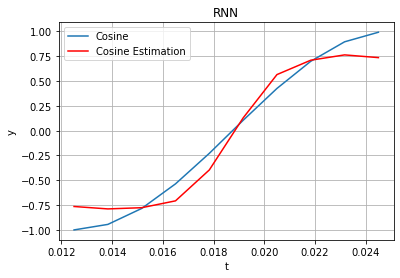

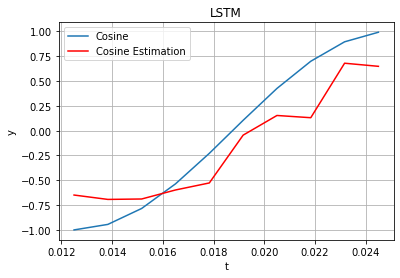

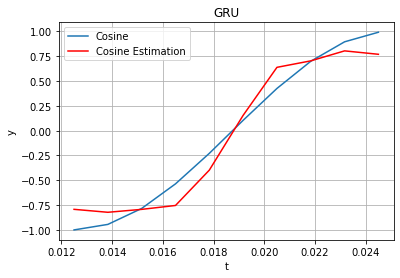

In [132]:
n_test_samples = 1

X_test = np.zeros((n_test_samples, n_features))
y_test = np.zeros((n_test_samples, n_features))

for i in range(n_test_samples):
    t1, t2 = findInterval(T)
    t = np.linspace(t1, t2, n_features)
    X_test[i] = A*np.sin(w*t)
    y_test[i] = A*np.cos(w*t)

X_test = torch.from_numpy(X_test.reshape((n_test_samples, n_features, -1))).float()
y_test = torch.from_numpy(y_test.reshape((n_test_samples, n_features, -1))).float()

trained_model_rnn.eval()
trained_model_lstm.eval()
trained_model_gru.eval()

for x, y in zip(X_test, y_test):
    
    x, y = Variable(x.to(device)), Variable(y.to(device))
    with torch.no_grad():
        _, output_rnn = trained_model_rnn(x, model.init_hidden())
        _, _, output_lstm = trained_model_lstm(x, model.init_hidden(), model.init_cell())
        _, output_gru = trained_model_gru(x, model.init_hidden())
 
    plt.plot(t, y)
    plt.plot(t, output_rnn, color = 'r')
    plt.title('RNN')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend(['Cosine','Cosine Estimation'])
    plt.axis('tight')
    plt.grid()
    plt.show()
    
    plt.plot(t, y)
    plt.plot(t, output_lstm, color = 'r')
    plt.title('LSTM')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend(['Cosine','Cosine Estimation'])
    plt.axis('tight')
    plt.grid()
    plt.show()
    
    plt.plot(t, y)
    plt.plot(t, output_gru, color = 'r')
    plt.title('GRU')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend(['Cosine','Cosine Estimation'])
    plt.axis('tight')
    plt.grid()
    plt.show()

# np.linalg.norm(out.view(-1) - test_cos.view(-1))



    
    

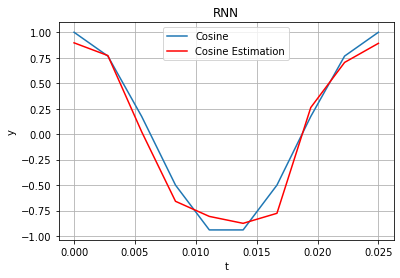

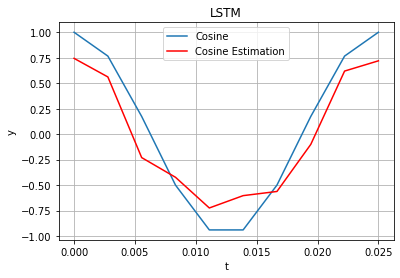

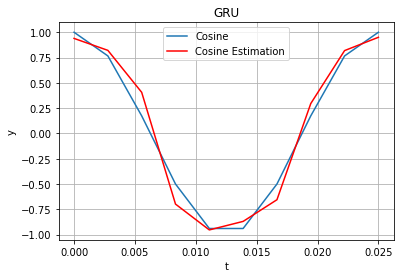

In [130]:
t = np.linspace(0, T, n_features)

x = Variable(torch.from_numpy(np.sin(w*t).reshape(n_features, -1)).float())
y = Variable(torch.from_numpy(np.cos(w*t).reshape(n_features, -1)).float())

with torch.no_grad():
    _, output_rnn = trained_model_rnn(x, model.init_hidden())
    _, _, output_lstm = trained_model_lstm(x, model.init_hidden(), model.init_cell())
    _, output_gru = trained_model_gru(x, model.init_hidden())
    
    plt.plot(t, y)
    plt.plot(t, output_rnn, color = 'r')
    plt.title('RNN')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend(['Cosine','Cosine Estimation'])
    plt.axis('tight')
    plt.grid()
    plt.show()
    
    plt.plot(t, y)
    plt.plot(t, output_lstm, color = 'r')
    plt.title('LSTM')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend(['Cosine','Cosine Estimation'])
    plt.axis('tight')
    plt.grid()
    plt.show()
    
    plt.plot(t, y)
    plt.plot(t, output_gru, color = 'r')
    plt.title('GRU')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend(['Cosine','Cosine Estimation'])
    plt.axis('tight')
    plt.grid()
    plt.show()
    



RNN - LSTM & GRU

Τα απλά αναδρομικά νευρωνικά δίκτυα (RNNs) έχουν short-term memory. Αυτό σημαίνει ότι στην περίπτωση που πρέπει να μάθουν μια ακολουθία, όσο μεγαλύτερη είναι αυτή τόσο πιο μεγάλη δυσκολία εμφανίζουν στο να διατηρήσουν την πληροφορία από την αρχή της ακολουθίας έως το τέλος. Ουσιαστικά, κατά το back propagation συμβαίνει αυτό που ονομάζουμε vanishing gradients. Τα gradients είναι οι τιμές οι οποίες συνεισφέρουν στην ανανέωση των βαρών του δικτύου. Όταν μετά από πολλές παραγωγήσεις αποκτήσουν εξαιρετικά μικρές τιμές τότε απλά καταλήγουν να μη συνεισφέρουν στην εκμάθηση του δικτύου. Τα LSTM και GRU δημιουργήθηκαν για την αντιμετώπιση του short-term memory απ'το οποίο πάσχει το απλό RNN. Αυτό που πρακτικά συμβαίνει είναι ότι συντηρείται πληροφορία απ'τα gradients μέσω όμως κάποιας επιλογής, δηλαδή εφαρμόζουν μια διαλογή για το ποια πληροφορία πρέπει να κρατήσω και ποια να πετάξω. Επομένως, τα LSTM και GRU είναι καλά σε προβλήματα επεξεργασίας μεγάλων ακολουθιών.


